<a href="https://colab.research.google.com/github/v1t3ls0n/ml_intro_course_mmn11/blob/main/notebooks/%D7%9E%D7%91%D7%95%D7%90%20%D7%9C%D7%9C%D7%9E%D7%99%D7%93%D7%94%20%D7%97%D7%99%D7%A9%D7%95%D7%91%D7%99%D7%AA%20-%20%D7%9E%D7%9E%D7%9F%2011%20-%20%D7%92%D7%99%D7%90%20%D7%95%D7%99%D7%98%D7%9C%D7%96%D7%95%D7%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maman 11 By Guy Vitelson


##**If you run this within Google Collab, Dont Worry!**
all the missing python files/directories/modules will be automatically feteched from my github repository

**My GitHub Profile** : https://github.com/v1t3ls0n

**The Repository:** https://github.com/v1t3ls0n/ml_intro_course_mmn11

# Overview



## MNIST Digit Classification Using Perceptron Learning Algorithm (PLA)

**Objective:**  
This notebook compares the performance of two variants of the Perceptron Learning Algorithm (PLA) on the MNIST digit classification task:
- **Clean PLA:** Standard perceptron without enhancements.
- **Pocket PLA:** Enhanced perceptron that stores the best-performing weights during training (using the Pocket algorithm).

**Dataset:**  
- MNIST dataset consisting of 60,000 training samples and 10,000 test samples.
- The images are normalized to the range [0, 1] and a bias term is added, resulting in input samples with 785 features.

**Evaluation Metrics:**  
- **Confusion Matrices:** Provides a detailed view of how well each digit is classified.
- **Overall Accuracy (ACC):** Defined as \(\text{ACC} = \frac{TP + TN}{TP + TN + FP + FN}\).
- **Sensitivity (True Positive Rate, TPR):** For each digit, calculated as \(\text{TPR} = \frac{TP}{TP + FN}\), showing the model’s ability to correctly identify the digit.
- **Selectivity (Specificity, TNR):** For each digit, calculated as \(\text{TNR} = \frac{TN}{TN + FP}\), showing the model’s ability to correctly identify negatives.
- **Training and Testing Error Curves:** Visualized as a function of iteration for detailed analysis of learning dynamics.
- **Runtime:** The time taken to train the models.

**Goals:**  
- Evaluate and compare the model accuracy and robustness between Clean PLA and Pocket PLA.
- Analyze and visualize the performance through confusion matrices, error curves, and summary plots (accuracy, sensitivity, selectivity, and runtime vs. the number of iterations).
- Provide a comprehensive discussion on how training iterations affect the decision boundaries and the overall performance, particularly in the one-vs-all classification setup.

This notebook integrates detailed quantitative evaluation with comprehensive visualizations to thoroughly analyze the multi-class Perceptron performance on the MNIST dataset.

# Imports

## External Code Imports (pip packages)

In [12]:
import os
import shutil
import sys
import logging
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import time
import pandas as pd


## Fetch Missing Files For Google Colab Env

In [2]:

# %%capture run_output
# %matplotlib inline

if sys.platform != 'win32': # check if we are running on google collab
  repo_url = "https://github.com/v1t3ls0n/ml_intro_course_mmn11"
  repo_name = "ml_intro_course_mmn11"
  from tqdm.notebook import tqdm # type: ignore


  # Clone the repository if it doesn't exist
  if not os.path.exists(repo_name):
    os.system(f"git clone {repo_url}")

  # Construct the path to the repository directory
  repo_path = os.path.join(os.getcwd(), repo_name)

  # Add the repository directory to the Python path
  if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

  # --- Extract 'core' and 'notebooks' directories ---
  def extract_directories(source_dir, destination_dir, dir_names):
      for dir_name in dir_names:
          source_path = os.path.join(source_dir, dir_name)
          destination_path = os.path.join(destination_dir, dir_name)
          if os.path.exists(source_path):
              shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

  destination_path = "."
  # Extract the directories
  extract_directories(repo_path, destination_path, ["core"])
  project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
  sys.path.insert(0, project_root)
  if os.path.exists("ml_intro_course_mmn11"):
    shutil.rmtree("ml_intro_course_mmn11")
  if os.path.exists("sample_data"):
    shutil.rmtree("sample_data")
else:
  from tqdm import tqdm  # type: ignore
  current_dir = os.getcwd()  # Current working directory
  project_root = os.path.abspath(os.path.join(current_dir, '..'))  # Root directory of the project
  sys.path.insert(0, project_root)


## Internal Code Imports (original code)

In [3]:

# ========== Internal Code Imports ==========

#Logger
from core.logger.config import logger

# Data Preprocessing
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data

# Models
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron
from core.models.logistic_regression.softmax_lregression import SoftmaxRegression
from core.models.linear_regression.linear_regression import  LinearRegression

# Performance & Plotting
from core.analysis.evaluation_functions import (
    evaluate_model,
    aggregate_iteration_losses,
    aggregate_iteration_losses_softmax
)

from core.analysis.plotting import (
    plot_confusion_matrix_annotated,
    plot_error_curves,
    plot_accuracy_vs_max_iter,
    plot_runtime_vs_max_iter,
    plot_performance_summary_extended,
    plot_train_curves_three_models,
    plot_metric_vs_learning_rate,
    plot_accuracy_vs_max_iter_4models,
    plot_runtime_vs_max_iter_4models,
    plot_accuracy_vs_runtime,
    plot_performance_summary_extended_by_runtime,
    plot_performance_summary_4models_by_runtime,
    plot_accuracy_vs_runtime_4models
)

logger = logging.getLogger("MyGlobalLogger") # configured in core/logger/config.py


# Choose Run Parameters **(Significant Effect On Model's Runtime!)**

In [4]:
#######################################################################
# SEPARATE RUN PARAMETERS FOR PERCEPTRONS vs. REGRESSIONS
#######################################################################

# Perceptrons (Clean & Pocket) iteration-based run
perceptron_max_iter_values = [20,50,100,1000]  # for Clean PLA & Pocket PLA

# Logging the run parameters
logger.info(f"=== Perceptron Run Parameters ===")
logger.info(f"max_iter_values = {perceptron_max_iter_values}")

# Regression (Softmax & Linear) run parameters.
learning_rates = [0.1]
iteration_counts = [20,50,100,1000,10000]

regression_run_configs = [
    {
        "label": f"LR={lr}/Iter={it}",
        "learning_rate": lr,
        "max_iter": it
    }
    for lr in learning_rates
    for it in iteration_counts
]

logger.info(f"=== Regression Run Parameters ===")
for cfg in regression_run_configs:
    logger.info(f"{cfg['label']} -> learning_rate={cfg['learning_rate']}, max_iter={cfg['max_iter']}")


2025-03-18 17:55:06,491 - INFO - === Perceptron Run Parameters ===
2025-03-18 17:55:06,491 - INFO - max_iter_values = [20, 50, 100, 1000]
2025-03-18 17:55:06,492 - INFO - === Regression Run Parameters ===
2025-03-18 17:55:06,492 - INFO - LR=0.1/Iter=10000 -> learning_rate=0.1, max_iter=10000
2025-03-18 17:55:06,491 - INFO - max_iter_values = [20, 50, 100, 1000]
2025-03-18 17:55:06,492 - INFO - === Regression Run Parameters ===
2025-03-18 17:55:06,492 - INFO - LR=0.1/Iter=10000 -> learning_rate=0.1, max_iter=10000


# Load and Preprocess the MNIST Dataset


In [5]:
'''
We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`).
The preprocessing step normalizes each image to the range [0, 1] and adds a bias term, resulting in input samples with 785 features.
This setup ensures that the training set contains 60,000 samples and the test set 10,000 samples, preparing the data for the subsequent classification tasks.
'''

# New section
# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()


logger.info("Raw MNIST data shapes: X_raw: %s, y_raw: %s", X_raw.shape, y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
logger.info("Preprocessed shape: %s", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]

logger.info("Train set: X_train: %s, y_train: %s", X_train.shape, y_train.shape)
logger.info("Test set: X_test: %s, y_test: %s", X_test.shape, y_test.shape)



2025-03-18 17:55:08,731 - INFO - Raw MNIST data shapes: X_raw: (70000, 784), y_raw: (70000,)
2025-03-18 17:55:08,892 - INFO - Preprocessed shape: (70000, 785)
2025-03-18 17:55:08,893 - INFO - Train set: X_train: (60000, 785), y_train: (60000,)
2025-03-18 17:55:08,893 - INFO - Test set: X_test: (10000, 785), y_test: (10000,)


# Train


In [6]:
# =========================================================
# TRAINING CELL
# =========================================================

# 1) Dictionaries to store trained models
trained_models_clean   = {}
trained_models_pocket  = {}
trained_models_softmax = {}
trained_models_linear  = {}

# 2) Train Regression Models (Softmax & Linear)
logger.info("=== TRAINING REGRESSION MODELS (Softmax & Linear) ===")
for cfg in tqdm(regression_run_configs, desc="Train Regressions"):
    lr_val = cfg["learning_rate"]
    max_iter_val = cfg["max_iter"]
    label = cfg["label"]  # e.g. "LR=0.001/Iter=1000"

    # --- Softmax ---
    logger.info(f"--- Softmax {label} ---")
    s_model = SoftmaxRegression(
        num_classes=10,
        max_iter=max_iter_val,
        learning_rate=lr_val,
        adaptive_lr=True
    )
    s_model.fit(X_train, y_train)
    trained_models_softmax[(lr_val, max_iter_val)] = s_model

    # --- Linear ---
    logger.info(f"--- Linear Regression {label} ---")
    lin_model = LinearRegression(
        num_classes=10,
        max_iter=max_iter_val,
        learning_rate=lr_val,
        adaptive_lr=True,
        early_stopping=False
    )
    lin_model.fit(X_train, y_train)
    trained_models_linear[(lr_val, max_iter_val)] = lin_model

logger.info("Training complete for Softmax and Linear.")

# 3) Train Perceptron Models (Clean & Pocket)
logger.info("=== TRAINING PERCEPTRON MODELS (Clean & Pocket) ===")
for max_iter in tqdm(perceptron_max_iter_values, desc="Train Clean & Pocket"):
    logger.info(f"--- Clean PLA, max_iter={max_iter} ---")
    clean_perc = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=False)
    clean_perc.fit(X_train, y_train)
    trained_models_clean[max_iter] = clean_perc

    logger.info(f"--- Pocket PLA, max_iter={max_iter} ---")
    pocket_perc = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=True)
    pocket_perc.fit(X_train, y_train)
    trained_models_pocket[max_iter] = pocket_perc

logger.info("Training complete for Clean PLA and Pocket PLA.")
logger.info("=== ALL TRAINING COMPLETE ===")


2025-03-18 17:55:08,900 - INFO - === TRAINING REGRESSION MODELS (Softmax & Linear) ===
Train Regressions:   0%|          | 0/1 [00:00<?, ?it/s]2025-03-18 17:55:08,902 - INFO - --- Softmax LR=0.1/Iter=10000 ---
2025-03-18 17:55:13,003 - INFO - Iter 100/10000, Loss: 0.2929, Avg Adaptive LR: 3.304968
2025-03-18 17:55:17,008 - INFO - Iter 200/10000, Loss: 0.2703, Avg Adaptive LR: 3.303410
2025-03-18 17:55:21,011 - INFO - Iter 300/10000, Loss: 0.2595, Avg Adaptive LR: 3.302667
2025-03-18 17:55:25,096 - INFO - Iter 400/10000, Loss: 0.2528, Avg Adaptive LR: 3.302201
2025-03-18 17:55:29,181 - INFO - Iter 500/10000, Loss: 0.2480, Avg Adaptive LR: 3.301869
2025-03-18 17:55:33,407 - INFO - Iter 600/10000, Loss: 0.2444, Avg Adaptive LR: 3.301616
2025-03-18 17:55:37,479 - INFO - Iter 700/10000, Loss: 0.2415, Avg Adaptive LR: 3.301414
2025-03-18 17:55:41,505 - INFO - Iter 800/10000, Loss: 0.2390, Avg Adaptive LR: 3.301246
2025-03-18 17:55:45,575 - INFO - Iter 900/10000, Loss: 0.2370, Avg Adaptive LR

# Evaluate

In [26]:
##################################################
# EVALUATION CELL (with pandas DataFrame)
##################################################


# 1) Evaluate Perceptrons: Clean & Pocket
accuracies_clean, accuracies_pocket = [], []
runtimes_clean,   runtimes_pocket   = [], []
sensitivities_clean, sensitivities_pocket = [], []
selectivities_clean, selectivities_pocket = [], []

conf_clean, conf_pocket = [], []
meta_clean, meta_pocket = [], []

for max_iter in tqdm(perceptron_max_iter_values, desc="Evaluate Clean & Pocket"):
    # === Evaluate Clean PLA ===
    c_model = trained_models_clean[max_iter]
    cm_c, acc_c, s_c, sp_c, rt_c, ex_c = evaluate_model(
        c_model, X_test, y_test, classes=range(10), model_name="Clean PLA"
    )
    accuracies_clean.append(acc_c)
    runtimes_clean.append(rt_c)
    sensitivities_clean.append(np.mean(s_c))
    selectivities_clean.append(np.mean(sp_c))
    conf_clean.append(cm_c)

    cdict = {
        "max_iter": max_iter,
        "accuracy": acc_c,
        "runtime": rt_c,
        "avg_sensitivity": np.mean(s_c),
        "avg_selectivity": np.mean(sp_c),
        "method": "Clean PLA"
    }
    cdict.update(ex_c)
    meta_clean.append(cdict)

    # === Evaluate Pocket PLA ===
    p_model = trained_models_pocket[max_iter]
    cm_p, acc_p, s_p, sp_p, rt_p, ex_p = evaluate_model(
        p_model, X_test, y_test, classes=range(10), model_name="Pocket PLA"
    )
    accuracies_pocket.append(acc_p)
    runtimes_pocket.append(rt_p)
    sensitivities_pocket.append(np.mean(s_p))
    selectivities_pocket.append(np.mean(sp_p))
    conf_pocket.append(cm_p)

    pdict = {
        "max_iter": max_iter,
        "accuracy": acc_p,
        "runtime": rt_p,
        "avg_sensitivity": np.mean(s_p),
        "avg_selectivity": np.mean(sp_p),
        "method": "Pocket PLA"
    }
    pdict.update(ex_p)
    meta_pocket.append(pdict)

# Aggregated iteration-level training curves for Perceptrons
clean_train_curve = aggregate_iteration_losses(
    [trained_models_clean[m] for m in perceptron_max_iter_values]
)
pocket_train_curve = aggregate_iteration_losses(
    [trained_models_pocket[m] for m in perceptron_max_iter_values]
)

# 2) Evaluate Regression Models: Softmax & Linear
accuracies_softmax = []
runtimes_softmax   = []
sensitivities_soft = []
selectivities_soft = []
conf_soft          = []
meta_soft          = []

accuracies_linear = []
runtimes_linear   = []
sensitivities_lin = []
selectivities_lin = []
conf_linear       = []
meta_linear       = []

for cfg in tqdm(regression_run_configs, desc="Evaluate Regressions"):
    lr_val = cfg["learning_rate"]
    max_iter_val = cfg["max_iter"]
    label = cfg["label"]

    # === Evaluate Softmax ===
    s_model = trained_models_softmax[(lr_val, max_iter_val)]
    cm_s, a_s, se_s, sp_s, r_s, ex_s = evaluate_model(
        s_model, X_test, y_test, classes=range(10),
        model_name=f"Softmax ({label})"
    )
    accuracies_softmax.append(a_s)
    runtimes_softmax.append(r_s)
    sensitivities_soft.append(np.mean(se_s))
    selectivities_soft.append(np.mean(sp_s))
    conf_soft.append(cm_s)

    ms = {
        "label": label,
        "learning_rate": lr_val,
        "max_iter": max_iter_val,
        "accuracy": a_s,
        "runtime": r_s,
        "avg_sensitivity": np.mean(se_s),
        "avg_selectivity": np.mean(sp_s),
        "method": "Softmax"
    }
    ms.update(ex_s)
    meta_soft.append(ms)

    # === Evaluate Linear ===
    lin_model = trained_models_linear[(lr_val, max_iter_val)]
    cm_l, a_l, se_l, sp_l, r_l, ex_l = evaluate_model(
        lin_model, X_test, y_test, classes=range(10),
        model_name=f"Linear ({label})"
    )
    accuracies_linear.append(a_l)
    runtimes_linear.append(r_l)
    sensitivities_lin.append(np.mean(se_l))
    selectivities_lin.append(np.mean(sp_l))
    conf_linear.append(cm_l)

    ml = {
        "label": label,
        "learning_rate": lr_val,
        "max_iter": max_iter_val,
        "accuracy": a_l,
        "runtime": r_l,
        "avg_sensitivity": np.mean(se_l),
        "avg_selectivity": np.mean(sp_l),
        "method": "Linear Regression"
    }
    ml.update(ex_l)
    meta_linear.append(ml)


logger.info("Evaluation complete for Perceptrons & Regressions.")


# 1) Build the DataFrame of all model results
all_rows = []

# A) Clean PLA
for i, max_iter in tqdm(
    enumerate(perceptron_max_iter_values),
    desc="Collecting Clean PLA",
    total=len(perceptron_max_iter_values)
):
    all_rows.append({
        'model': 'Clean PLA',
        'max_iter': max_iter,
        'runtime': runtimes_clean[i],
        'accuracy': accuracies_clean[i],
        'sensitivity': sensitivities_clean[i],
        'selectivity': selectivities_clean[i]
    })

# B) Pocket PLA
for i, max_iter in tqdm(
    enumerate(perceptron_max_iter_values),
    desc="Collecting Pocket PLA",
    total=len(perceptron_max_iter_values)
):
    all_rows.append({
        'model': 'Pocket PLA',
        'max_iter': max_iter,
        'runtime': runtimes_pocket[i],
        'accuracy': accuracies_pocket[i],
        'sensitivity': sensitivities_pocket[i],
        'selectivity': selectivities_pocket[i]
    })

# C) Softmax
for i, row_meta in tqdm(
    enumerate(meta_soft),
    desc="Collecting Softmax",
    total=len(meta_soft)
):
    all_rows.append({
        'model': 'Softmax',
        'max_iter': row_meta['max_iter'],
        'runtime': runtimes_softmax[i],
        'accuracy': accuracies_softmax[i],
        'sensitivity': sensitivities_soft[i],
        'selectivity': selectivities_soft[i]
    })

# D) Linear
for i, row_meta in tqdm(
    enumerate(meta_linear),
    desc="Collecting Linear",
    total=len(meta_linear)
):
    all_rows.append({
        'model': 'Linear',
        'max_iter': row_meta['max_iter'],
        'runtime': runtimes_linear[i],
        'accuracy': accuracies_linear[i],
        'sensitivity': sensitivities_lin[i],
        'selectivity': selectivities_lin[i]
    })




Evaluate Clean & Pocket:   0%|          | 0/4 [00:00<?, ?it/s]2025-03-18 19:02:13,178 - INFO - Built-in Confusion Matrix:
[[ 941    0    4    4    0   19   11    1    0    0]
 [   0 1066   31   17    1   16    4    0    0    0]
 [  20    6  899   38   19    5   26   17    2    0]
 [   8    1   31  901    1   40    7   19    0    2]
 [   4    7    8    3  908   15   23    5    2    7]
 [  33    6   13   73   19  716   21    8    0    3]
 [  22    5   14    2   10   26  879    0    0    0]
 [   7   23   49    6   10    1    4  923    0    5]
 [  12   17   93  181   14  471   25   32  121    8]
 [  18    9   27   22  293   80    5  174    0  381]]
2025-03-18 19:02:13,179 - INFO - Overall Accuracy: 77.35%
2025-03-18 19:02:13,180 - INFO - Class '0': TPR=0.96, TNR=0.99
2025-03-18 19:02:13,181 - INFO - Class '1': TPR=0.94, TNR=0.99
2025-03-18 19:02:13,181 - INFO - Class '2': TPR=0.87, TNR=0.97
2025-03-18 19:02:13,181 - INFO - Class '3': TPR=0.89, TNR=0.96
2025-03-18 19:02:13,182 - INFO - Clas

# Visualize (Generate Plots, Confusion Matricies, etc.)


2025-03-18 19:02:29,149 - INFO - Combined Results DataFrame:
        model  max_iter     runtime  accuracy  sensitivity  selectivity
0   Clean PLA        20   12.310775    0.7735     0.770718     0.974903
1   Clean PLA        50   24.071312    0.8545     0.850681     0.983826
2   Clean PLA       100   42.066668    0.8745     0.871954     0.986055
3   Clean PLA      1000  342.632614    0.8633     0.861587     0.984807
4  Pocket PLA        20   12.465996    0.8377     0.836411     0.981993
5  Pocket PLA        50   24.236941    0.8753     0.873371     0.986151
6  Pocket PLA       100   42.087079    0.8964     0.894188     0.988493
7  Pocket PLA      1000  343.113562    0.9045     0.903203     0.989398
8     Softmax     10000  311.155568    0.9264     0.925356     0.991827
9      Linear     10000  328.234917    0.8429     0.839643     0.982510


,model,max_iter,runtime,accuracy,sensitivity,selectivity
0,Clean PLA,20,12.310775,0.7735,0.770718,0.974903
1,Clean PLA,50,24.071312,0.8545,0.850681,0.983826
2,Clean PLA,100,42.066668,0.8745,0.871954,0.986055
3,Clean PLA,1000,342.632614,0.8633,0.861587,0.984807
4,Pocket PLA,20,12.465996,0.8377,0.836411,0.981993
5,Pocket PLA,50,24.236941,0.8753,0.873371,0.986151
6,Pocket PLA,100,42.087079,0.8964,0.894188,0.988493
7,Pocket PLA,1000,343.113562,0.9045,0.903203,0.989398
8,Softmax,10000,311.155568,0.9264,0.925356,0.991827
9,Linear,10000,328.234917,0.8429,0.839643,0.982510


2025-03-18 19:02:29,154 - INFO - === Plotting ALL Confusion Matrices ===
Confusions: Clean PLA:   0%|          | 0/4 [00:00<?, ?it/s]

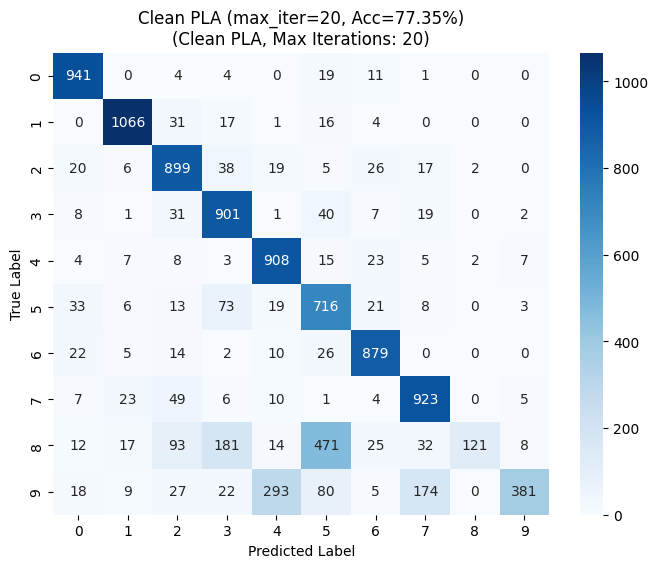

Confusions: Clean PLA:  25%|██▌       | 1/4 [00:00<00:00,  7.65it/s]

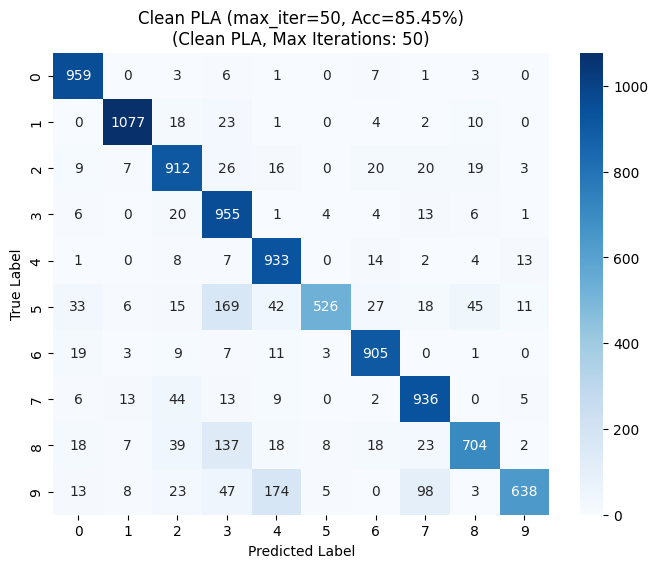

Confusions: Clean PLA:  50%|█████     | 2/4 [00:00<00:00,  8.25it/s]

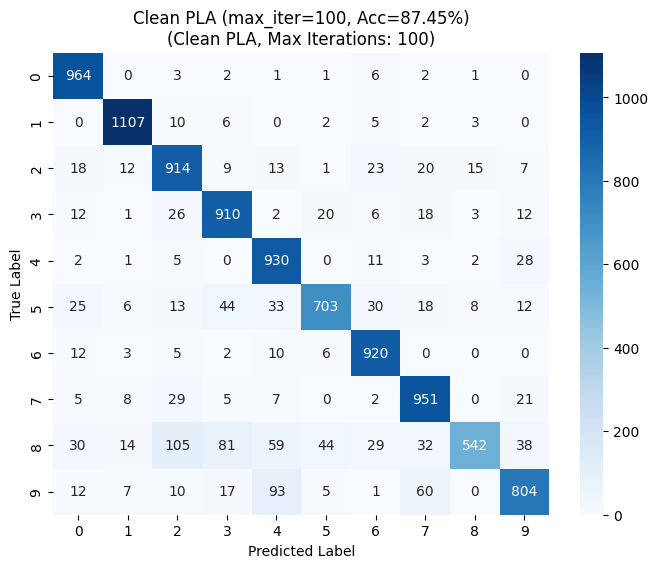

Confusions: Clean PLA:  75%|███████▌  | 3/4 [00:00<00:00,  8.41it/s]

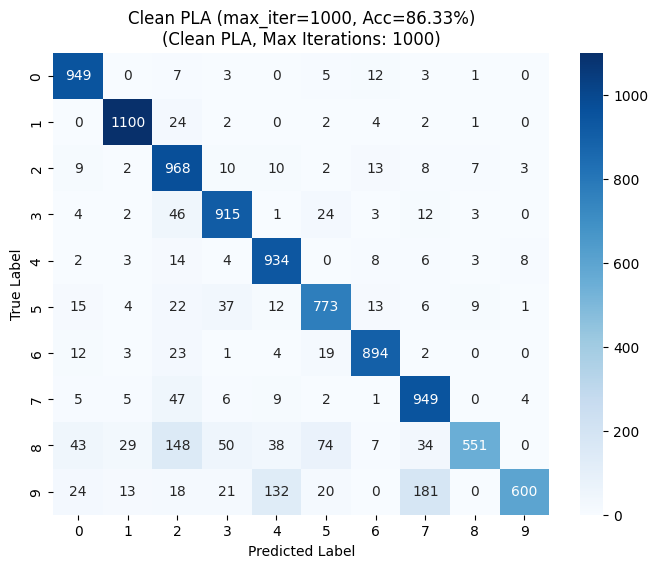

Confusions: Pocket PLA:   0%|          | 0/4 [00:00<?, ?it/s]

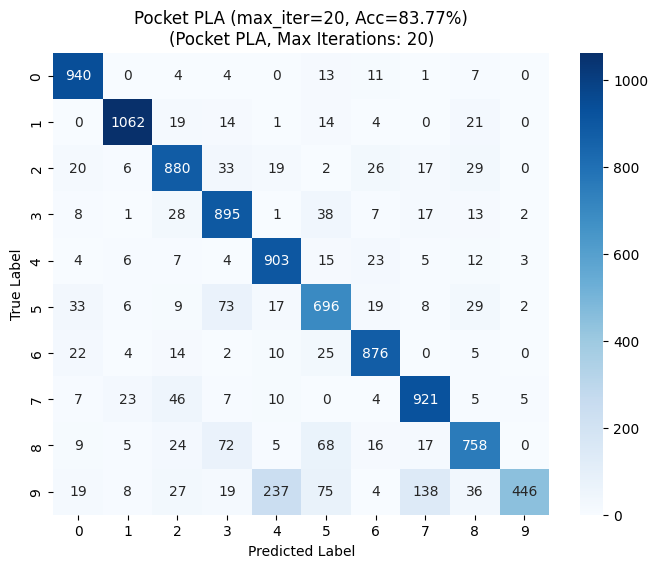

Confusions: Pocket PLA:  25%|██▌       | 1/4 [00:00<00:00,  8.53it/s]

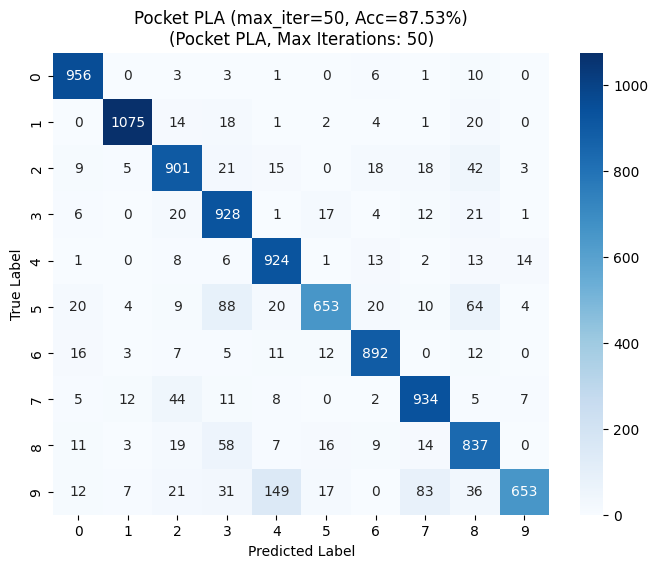

Confusions: Pocket PLA:  50%|█████     | 2/4 [00:00<00:00,  8.63it/s]

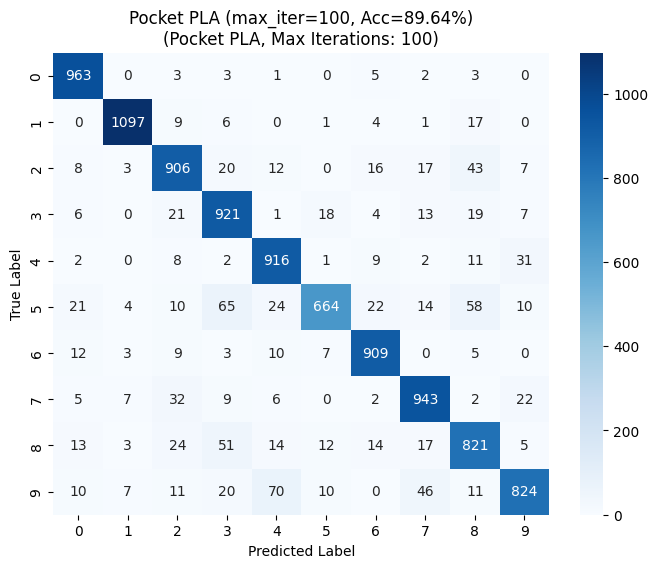

Confusions: Pocket PLA:  75%|███████▌  | 3/4 [00:00<00:00,  8.31it/s]

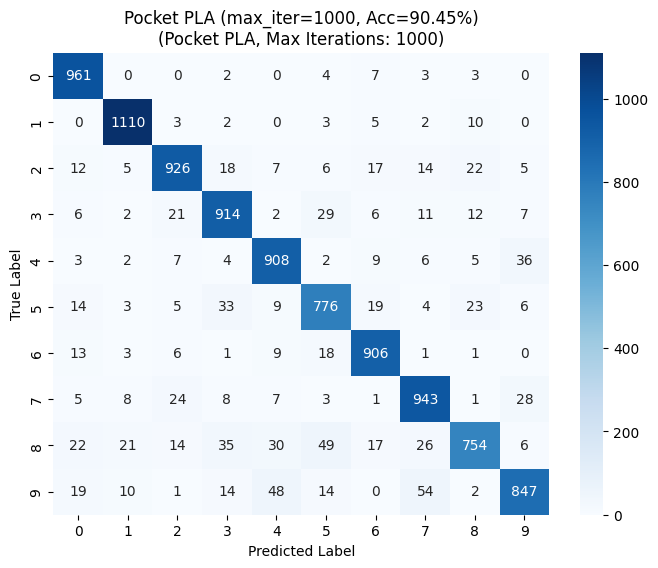

Confusions: Softmax:   0%|          | 0/1 [00:00<?, ?it/s]

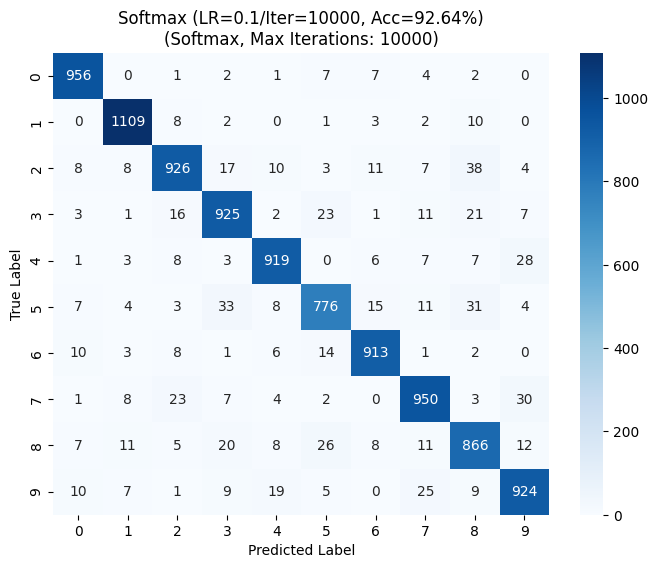

Confusions: Linear:   0%|          | 0/1 [00:00<?, ?it/s]

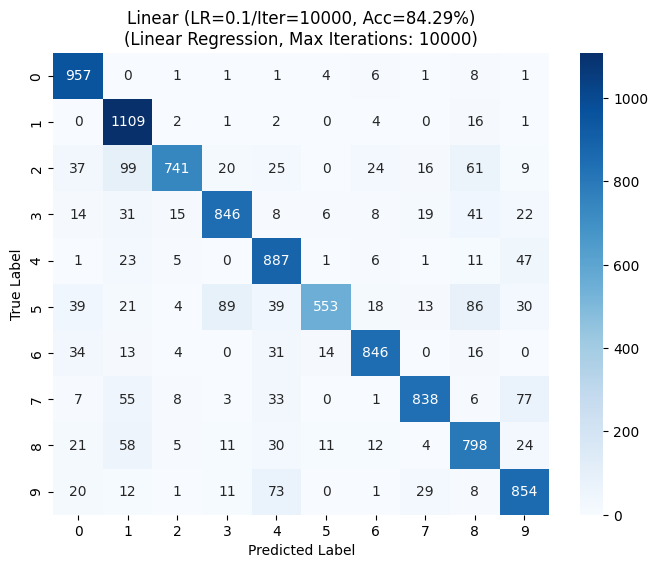

Confusions: Linear: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]
2025-03-18 19:02:30,339 - INFO - === Iteration-Level Visualization (All Models) ===


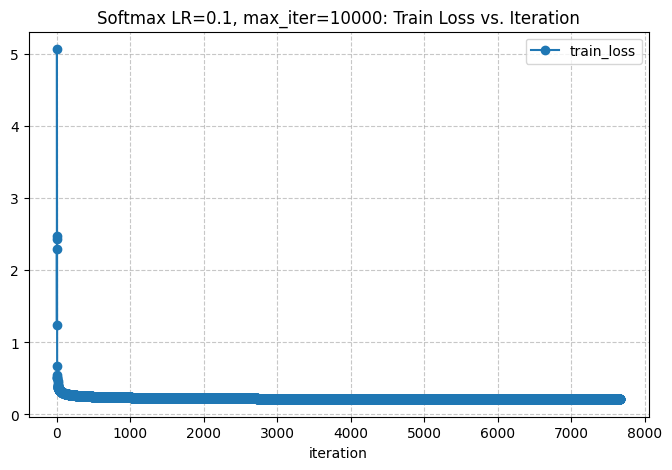

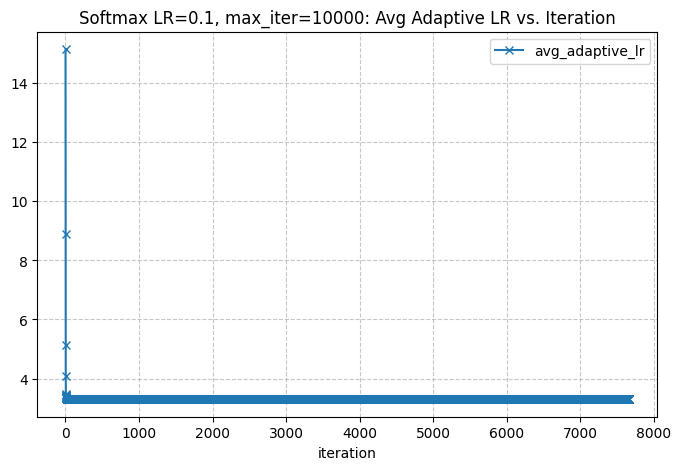

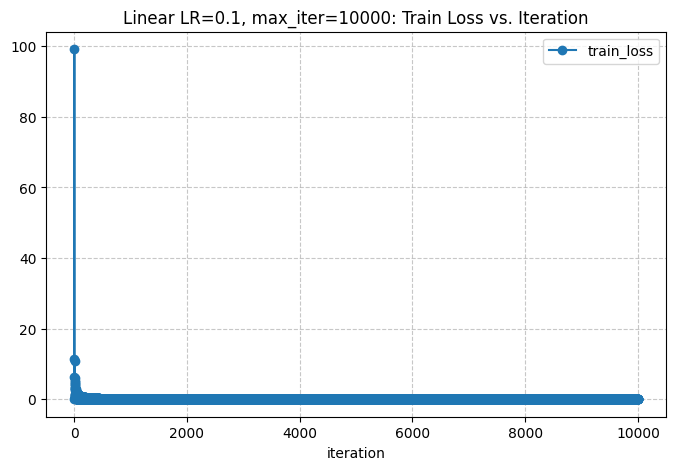

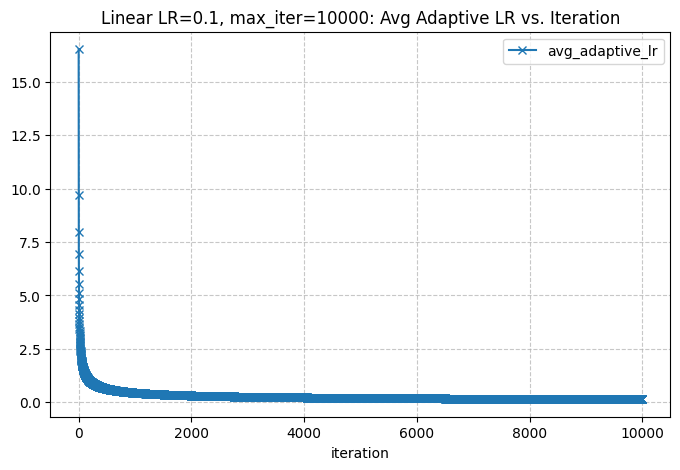

2025-03-18 19:02:30,610 - INFO - === Pandas + Seaborn Plots ===


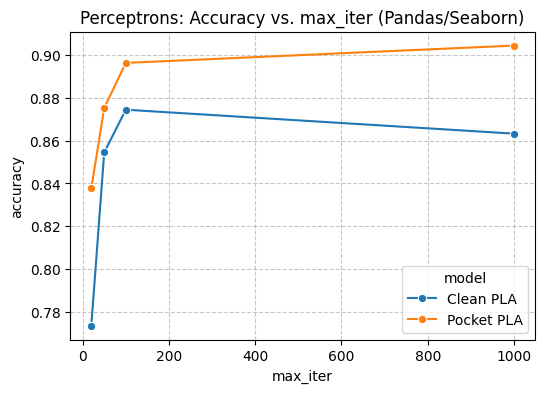

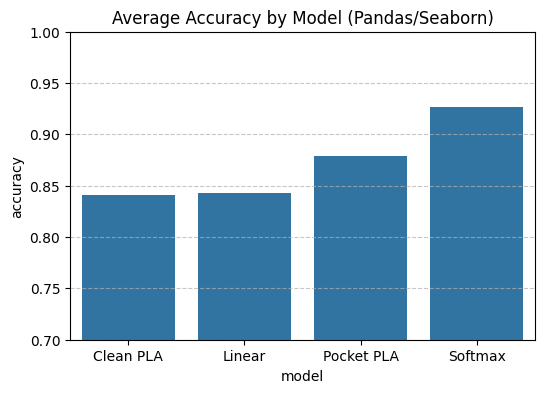

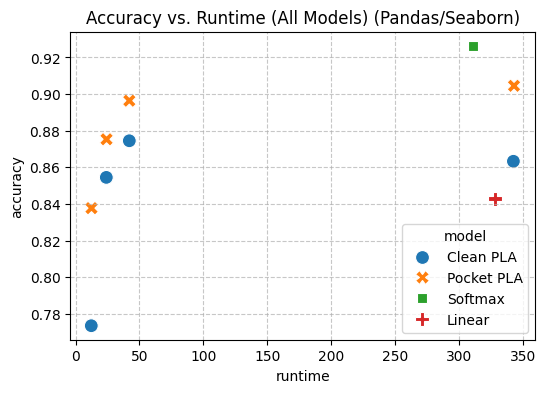

2025-03-18 19:02:30,798 - INFO - === Custom Summaries (Aggregated Curves, etc.) ===


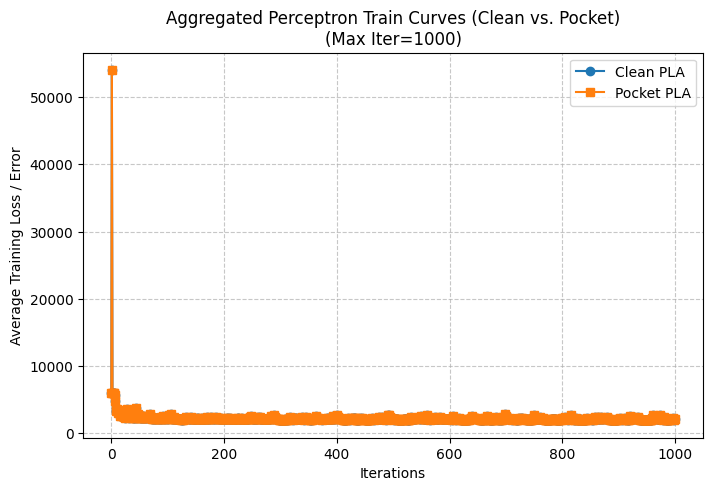

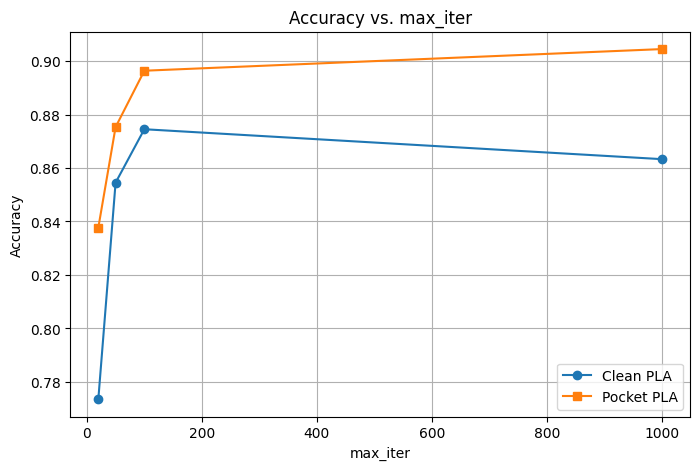

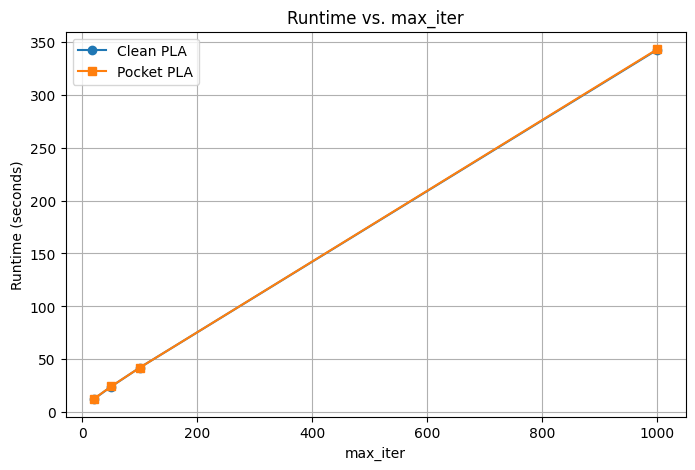

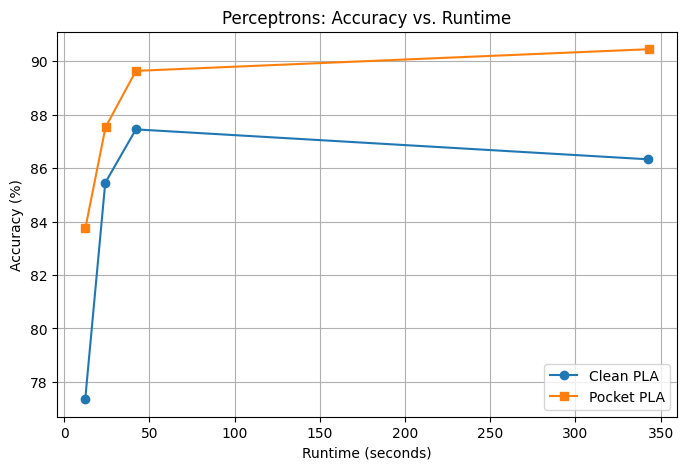

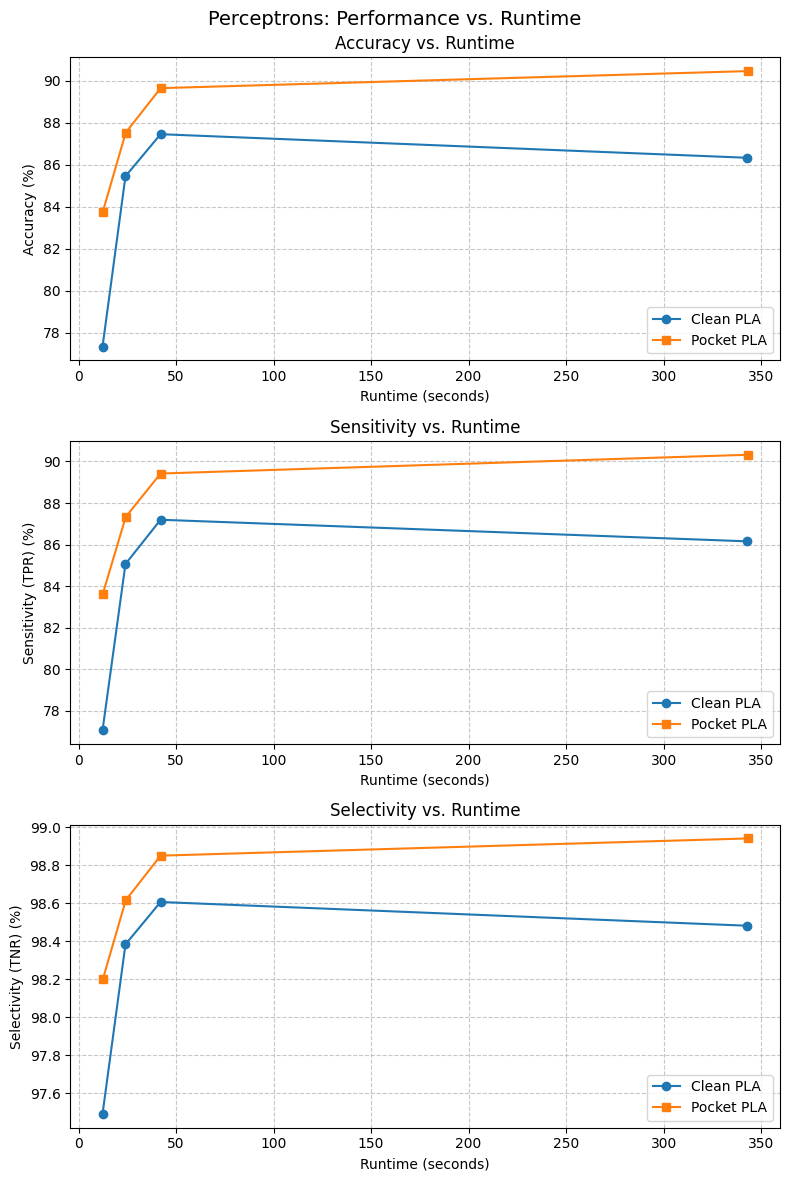

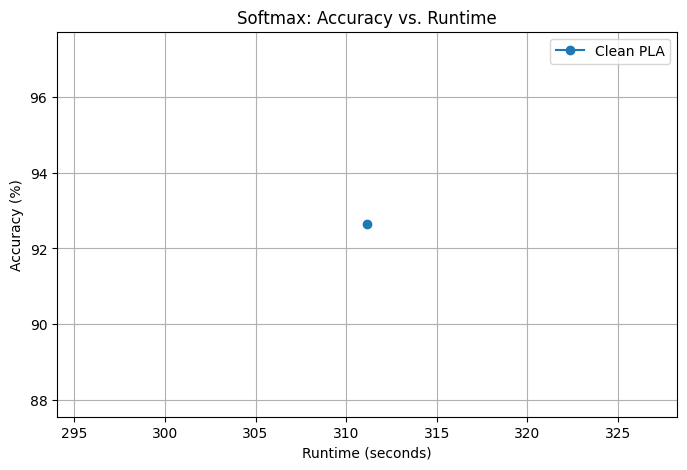

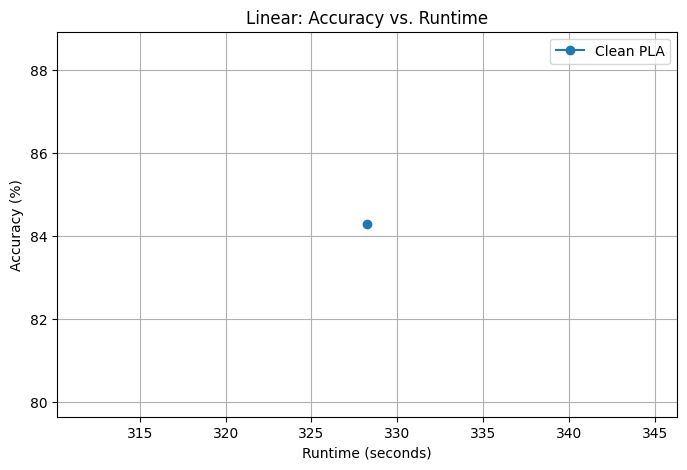

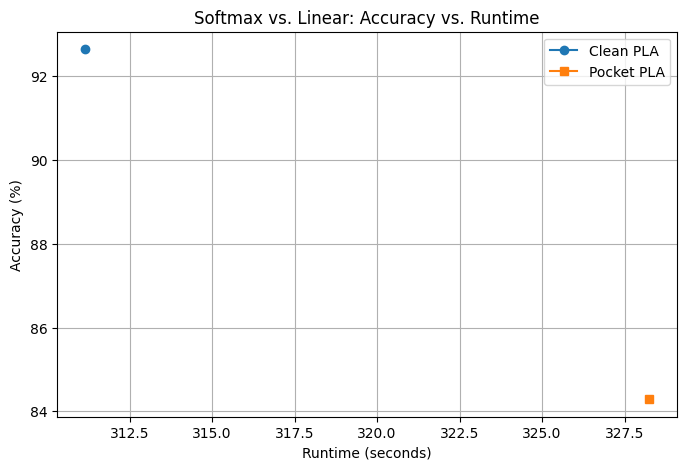

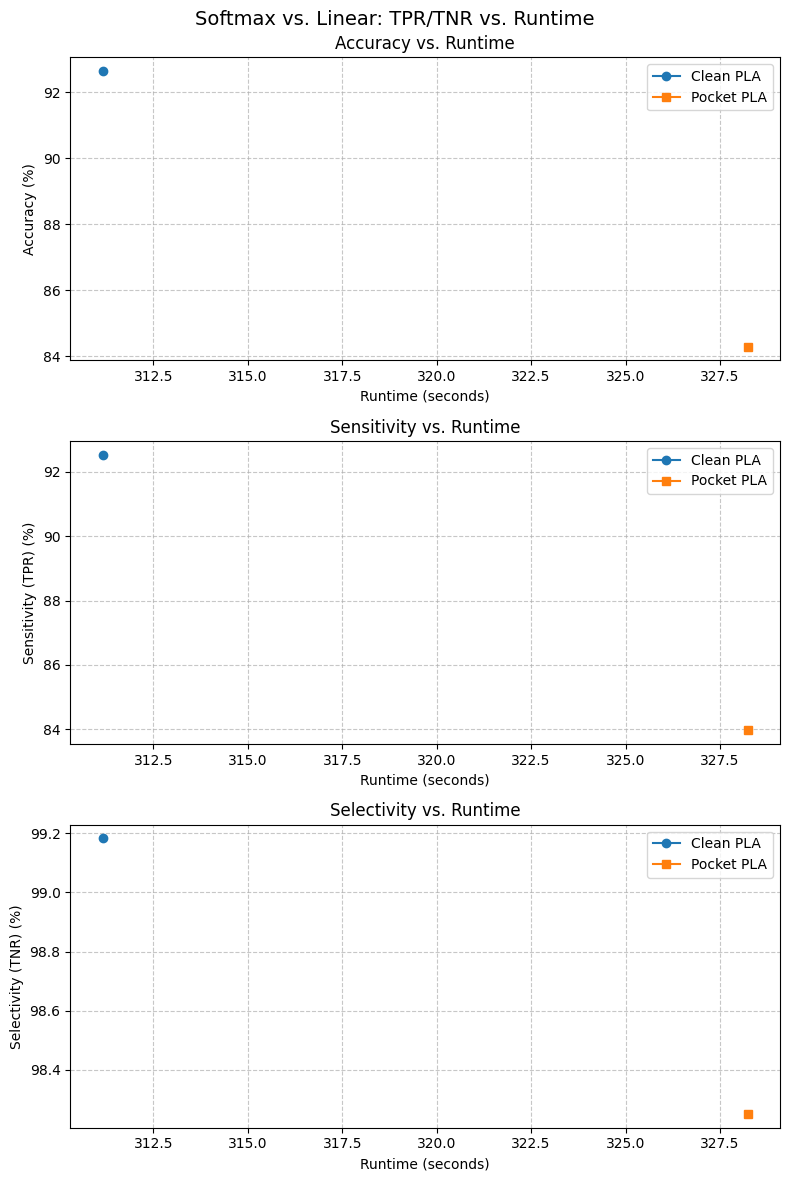

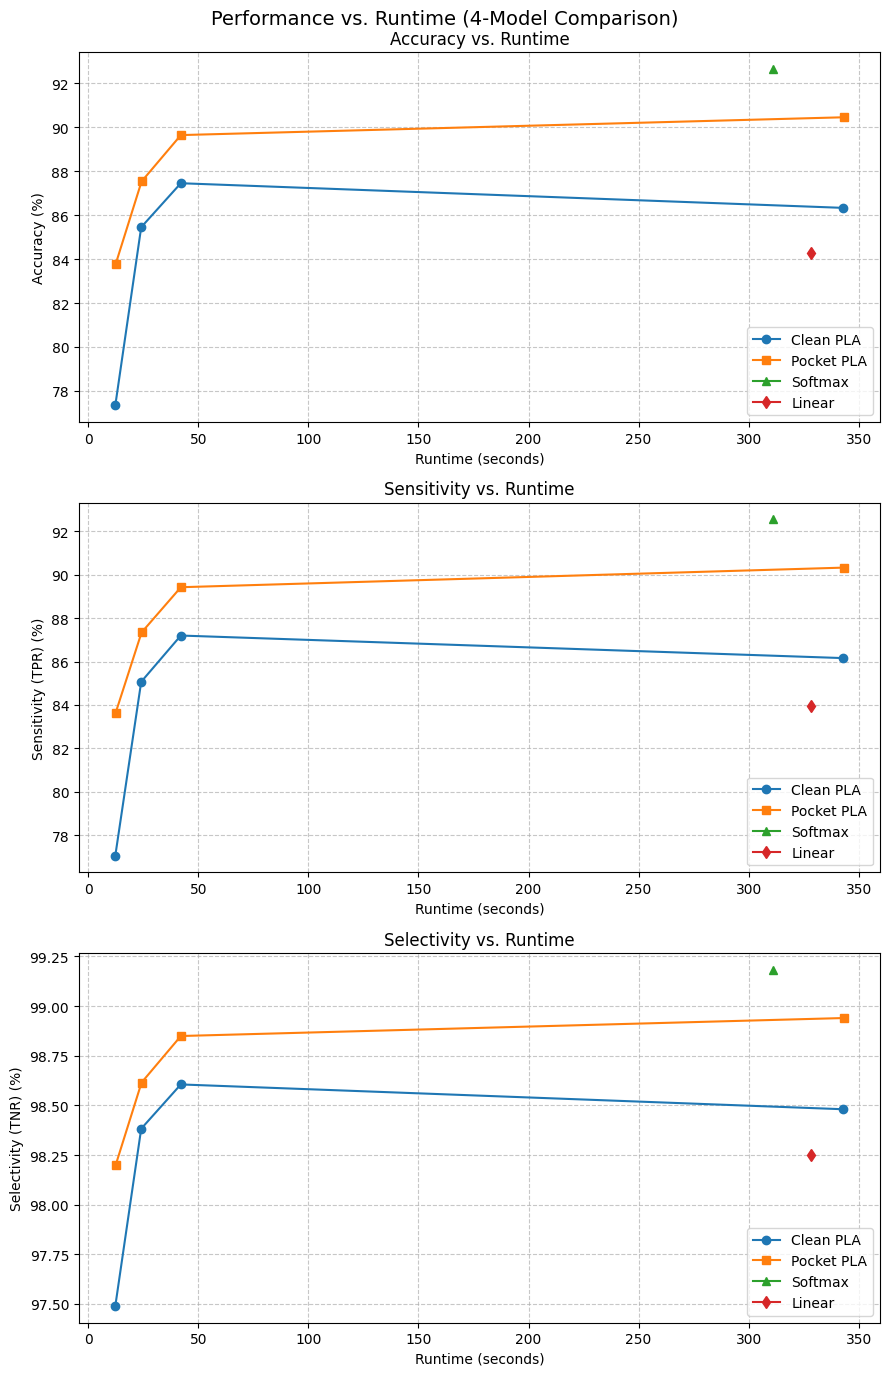

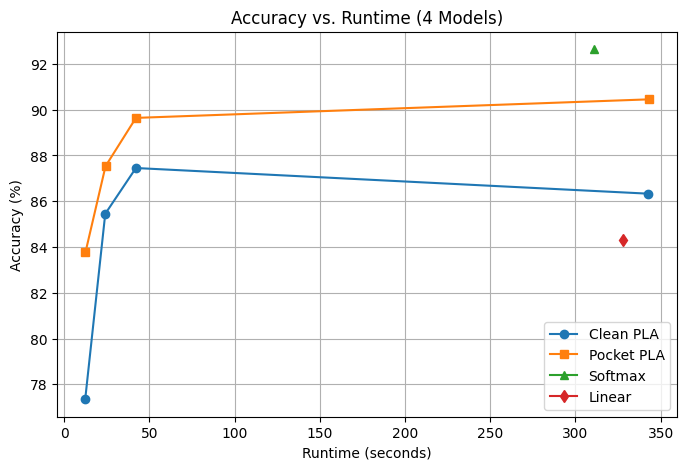

2025-03-18 19:02:31,949 - INFO - === All Visualizations Complete ===


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

##################################################
# 1) CREATE A SINGLE PANDAS DATAFRAME FOR ALL RESULTS
##################################################
all_rows = []

# (A) Clean PLA
for i, max_iter in tqdm(
    enumerate(perceptron_max_iter_values),
    desc="Collecting Clean PLA",
    total=len(perceptron_max_iter_values)
):
    all_rows.append({
        'model': 'Clean PLA',
        'max_iter': max_iter,
        'runtime': runtimes_clean[i],
        'accuracy': accuracies_clean[i],
        'sensitivity': sensitivities_clean[i],
        'selectivity': selectivities_clean[i]
    })

# (B) Pocket PLA
for i, max_iter in tqdm(
    enumerate(perceptron_max_iter_values),
    desc="Collecting Pocket PLA",
    total=len(perceptron_max_iter_values)
):
    all_rows.append({
        'model': 'Pocket PLA',
        'max_iter': max_iter,
        'runtime': runtimes_pocket[i],
        'accuracy': accuracies_pocket[i],
        'sensitivity': sensitivities_pocket[i],
        'selectivity': selectivities_pocket[i]
    })

# (C) Softmax
for i, row_meta in tqdm(
    enumerate(meta_soft),
    desc="Collecting Softmax",
    total=len(meta_soft)
):
    all_rows.append({
        'model': 'Softmax',
        'max_iter': row_meta['max_iter'],
        'runtime': runtimes_softmax[i],
        'accuracy': accuracies_softmax[i],
        'sensitivity': sensitivities_soft[i],
        'selectivity': selectivities_soft[i]
    })

# (D) Linear
for i, row_meta in tqdm(
    enumerate(meta_linear),
    desc="Collecting Linear",
    total=len(meta_linear)
):
    all_rows.append({
        'model': 'Linear',
        'max_iter': row_meta['max_iter'],
        'runtime': runtimes_linear[i],
        'accuracy': accuracies_linear[i],
        'sensitivity': sensitivities_lin[i],
        'selectivity': selectivities_lin[i]
    })

df_results = pd.DataFrame(all_rows)
logger.info("Combined Results DataFrame:\n%s", df_results)
display(df_results.head(20))

############################################################################
# 2) CONFUSION MATRICES FOR ALL MODELS (GROUPED BY PLOT TYPE)
############################################################################

logger.info("=== Plotting ALL Confusion Matrices ===")

# 2A) Perceptron: Clean
for idx, meta in tqdm(enumerate(meta_clean), total=len(meta_clean), desc="Confusions: Clean PLA"):
    title = f"Clean PLA (max_iter={meta['max_iter']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_clean[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# 2B) Perceptron: Pocket
for idx, meta in tqdm(enumerate(meta_pocket), total=len(meta_pocket), desc="Confusions: Pocket PLA"):
    title = f"Pocket PLA (max_iter={meta['max_iter']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_pocket[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# 2C) Softmax
for idx, meta in tqdm(enumerate(meta_soft), total=len(meta_soft), desc="Confusions: Softmax"):
    title = f"Softmax ({meta['label']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_soft[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# 2D) Linear
for idx, meta in tqdm(enumerate(meta_linear), total=len(meta_linear), desc="Confusions: Linear"):
    title = f"Linear ({meta['label']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_linear[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )


############################################################################
# 3) ITERATION-LEVEL PLOTS (ALL MODELS)
############################################################################

logger.info("=== Iteration-Level Visualization (All Models) ===")

# 3A) Perceptron: Clean & Pocket
for max_iter, c_model in trained_models_clean.items():
    df_iter = c_model.get_iteration_df()
    if not df_iter.empty and "train_error" in df_iter.columns:
        title = f"Clean PLA max_iter={max_iter}: Train Error vs. Iteration"
        df_iter.plot(x="iteration", y="train_error", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

for max_iter, p_model in trained_models_pocket.items():
    df_iter = p_model.get_iteration_df()
    if not df_iter.empty and "train_error" in df_iter.columns:
        title = f"Pocket PLA max_iter={max_iter}: Train Error vs. Iteration"
        df_iter.plot(x="iteration", y="train_error", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

# 3B) Softmax
for (lr_val, max_iter_val), s_model in trained_models_softmax.items():
    df_iter = s_model.get_iteration_df()  # Must be implemented in your SoftmaxRegression
    if not df_iter.empty:
        title = f"Softmax LR={lr_val}, max_iter={max_iter_val}: Train Loss vs. Iteration"
        df_iter.plot(x="iteration", y="train_loss", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        if "test_loss" in df_iter.columns:
            title = f"Softmax LR={lr_val}, max_iter={max_iter_val}: Train & Test Loss"
            df_iter.plot(x="iteration", y=["train_loss","test_loss"], marker='o', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()

        if "avg_adaptive_lr" in df_iter.columns:
            title = f"Softmax LR={lr_val}, max_iter={max_iter_val}: Avg Adaptive LR vs. Iteration"
            df_iter.plot(x="iteration", y="avg_adaptive_lr", marker='x', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()

# 3C) Linear
for (lr_val, max_iter_val), lin_model in trained_models_linear.items():
    df_iter = lin_model.get_iteration_df()  # Must be implemented in your LinearRegression
    if not df_iter.empty:
        title = f"Linear LR={lr_val}, max_iter={max_iter_val}: Train Loss vs. Iteration"
        df_iter.plot(x="iteration", y="train_loss", marker='o', figsize=(8,5), title=title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        if "test_loss" in df_iter.columns:
            title = f"Linear LR={lr_val}, max_iter={max_iter_val}: Train & Test Loss"
            df_iter.plot(x="iteration", y=["train_loss","test_loss"], marker='o', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()

        if "avg_adaptive_lr" in df_iter.columns:
            title = f"Linear LR={lr_val}, max_iter={max_iter_val}: Avg Adaptive LR vs. Iteration"
            df_iter.plot(x="iteration", y="avg_adaptive_lr", marker='x', figsize=(8,5), title=title)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()


############################################################################
# 4) PANDAS + SEABORN PLOTS
############################################################################

logger.info("=== Pandas + Seaborn Plots ===")

# 4A) LINE PLOT: Accuracy vs. max_iter (Perceptrons Only)
df_perc = df_results[df_results['model'].isin(['Clean PLA','Pocket PLA'])].copy()
df_perc.sort_values(['model','max_iter'], inplace=True)

plt.figure(figsize=(6,4))
sns.lineplot(
    data=df_perc,
    x='max_iter', y='accuracy',
    hue='model', marker='o'
)
plt.title("Perceptrons: Accuracy vs. max_iter (Pandas/Seaborn)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 4B) BAR CHART: Average Accuracy by Model
df_mean = df_results.groupby('model', as_index=False)['accuracy'].mean()

plt.figure(figsize=(6,4))
sns.barplot(data=df_mean, x='model', y='accuracy')
plt.title("Average Accuracy by Model (Pandas/Seaborn)")
plt.ylim(0.7, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4C) SCATTER PLOT: Accuracy vs. Runtime, colored by model
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df_results,
    x='runtime', y='accuracy',
    hue='model', style='model',
    s=100
)
plt.title("Accuracy vs. Runtime (All Models) (Pandas/Seaborn)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


############################################################################
# 5) CUSTOM SUMMARY PLOTS (AGGREGATED CURVES, ETC.)
############################################################################

logger.info("=== Custom Summaries (Aggregated Curves, etc.) ===")

# 5A) Aggregated Perceptron Curves
plot_train_curves_three_models(
    clean_train_curve=clean_train_curve,
    pocket_train_curve=pocket_train_curve,
    softmax_train_curve=None,  # no Softmax aggregator
    title="Aggregated Perceptron Train Curves (Clean vs. Pocket)",
    max_iter=perceptron_max_iter_values[-1]
)

# 5B) Summaries for Perceptron
plot_accuracy_vs_max_iter(
    max_iter_values=perceptron_max_iter_values,
    accuracies_clean=accuracies_clean,
    accuracies_pocket=accuracies_pocket,
    accuracies_softmax=None
)

plot_runtime_vs_max_iter(
    max_iter_values=perceptron_max_iter_values,
    runtimes_clean=runtimes_clean,
    runtimes_pocket=runtimes_pocket,
    runtimes_softmax=None
)

plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_clean,
    accuracies_clean=accuracies_clean,
    runtimes_pocket=runtimes_pocket,
    accuracies_pocket=accuracies_pocket,
    title="Perceptrons: Accuracy vs. Runtime"
)

plot_performance_summary_extended_by_runtime(
    runtimes_clean=runtimes_clean,
    accuracies_clean=accuracies_clean,
    sensitivities_clean=sensitivities_clean,
    selectivities_clean=selectivities_clean,
    runtimes_pocket=runtimes_pocket,
    accuracies_pocket=accuracies_pocket,
    sensitivities_pocket=sensitivities_pocket,
    selectivities_pocket=selectivities_pocket,
    title="Perceptrons: Performance vs. Runtime"
)

# 5C) Summaries for Softmax & Linear
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    title="Softmax: Accuracy vs. Runtime"
)
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_linear,
    accuracies_clean=accuracies_linear,
    title="Linear: Accuracy vs. Runtime"
)
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    runtimes_pocket=runtimes_linear,
    accuracies_pocket=accuracies_linear,
    title="Softmax vs. Linear: Accuracy vs. Runtime"
)
plot_performance_summary_extended_by_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    sensitivities_clean=sensitivities_soft,
    selectivities_clean=selectivities_soft,
    runtimes_pocket=runtimes_linear,
    accuracies_pocket=accuracies_linear,
    sensitivities_pocket=sensitivities_lin,
    selectivities_pocket=selectivities_lin,
    title="Softmax vs. Linear: TPR/TNR vs. Runtime"
)

# 5D) 4-Model Comparison
plot_performance_summary_4models_by_runtime(
    runtimes_clean, accuracies_clean, sensitivities_clean, selectivities_clean,
    runtimes_pocket, accuracies_pocket, sensitivities_pocket, selectivities_pocket,
    runtimes_softmax, accuracies_softmax, sensitivities_soft, selectivities_soft,
    runtimes_linear, accuracies_linear, sensitivities_lin, selectivities_lin,
    title="Performance vs. Runtime (4-Model Comparison)"
)

plot_accuracy_vs_runtime_4models(
    rt_clean=runtimes_clean,
    acc_clean=accuracies_clean,
    rt_pocket=runtimes_pocket,
    acc_pocket=accuracies_pocket,
    rt_softmax=runtimes_softmax,
    acc_softmax=accuracies_softmax,
    rt_linear=runtimes_linear,
    acc_linear=accuracies_linear,
    title="Accuracy vs. Runtime (4 Models)"
)

logger.info("=== All Visualizations Complete ===")


# Final Results Summary



**Observations:**
- **Pocket PLA** consistently outperforms Clean PLA in both accuracy and sensitivity (TPR) across all tested iteration counts.
- Increasing `max_iter` improves performance, though gains tend to plateau beyond roughly 50–100 iterations.
- **Runtime** increases nearly linearly with `max_iter` for both methods, highlighting a clear trade-off between higher accuracy and computational cost.
- Perfect linear separation is not achieved—even at higher iteration counts, neither method reaches 100% accuracy, indicating that the dataset is not strictly linearly separable.

**Trade-off Analysis:**
- **Low Iterations (max_iter = 10–30):**  
  Fast training with modest accuracy and TPR, suitable for rapid prototyping or time-sensitive applications.
- **Medium Iterations (max_iter = 50–100):**  
  Balanced performance and runtime, capturing most achievable gains without excessive overhead.
- **High Iterations (max_iter > 100):**  
  Marginal performance improvements with significant runtime increase; diminishing returns for practical applications.

**Recommendations for Future Work:**
- Experiment with alternative update rules (e.g., adaptive learning rates) to accelerate convergence.
- Compare against more sophisticated models (e.g., Logistic Regression, SVMs, neural networks) for broader insights.
- Evaluate model robustness under noisy or adversarial conditions.

This comprehensive analysis—including confusion matrices, error curves, and summary plots—provides detailed insights into the performance of the multi-class Perceptron on MNIST and informs the optimal balance between training efficiency and classification performance.
